# Mapping sorted B cells on reference

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import os,sys
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.sparse
import anndata
import scrublet as scr

In [34]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/sortedBcells/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir
    

### Load scRNA-seq data

In [35]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/sorted_B_cells/'

In [36]:
sample_ls = [x for x in os.listdir(data_dir) if x.startswith('WSS')]

min_n_count = 2000; min_n_gene = 500; max_n_gene = 7000
adata_ls = []
for s in sample_ls:
    adata = sc.read_10x_h5(data_dir + s + '/filtered_feature_bc_matrix.h5')
    adata.obs_names = [s + "-" + x.strip("-1") for x in adata.obs_names]
    # calculate n_counts / n_genes per cell
    adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1
    adata.obs['n_genes'] = np.sum(adata.X>0,axis=1)

    # filter cells
    print("Filtering cells...")
    clist = []
    clist.append(np.array(adata.obs['n_counts'] > min_n_count))
    clist.append(np.array(adata.obs['n_genes'] > min_n_gene))
    clist.append(np.array(adata.obs['n_genes'] < max_n_gene))

    c = np.column_stack(clist).all(axis=1)
    adata = adata[c].copy()

    adata = adata[:,np.argsort(adata.var.gene_ids)]
    adata.obs['file'] = s

    mito_genes = adata.var_names.str.startswith('MT-')
    adata.obs['mito'] = (np.sum(adata.X[:, mito_genes],axis=1).A1) / (np.sum(adata.X,axis=1).A1)
    adata_ls.append(adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.


Filtering cells...


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtering cells...


Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtering cells...


Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.


Filtering cells...


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [37]:
for a in adata_ls:
    a.var['gene_name'] = a.var_names.copy()
    a.var_names = a.var['gene_ids'].copy()

In [38]:
sortedB_adata = anndata.concat(adata_ls)

In [39]:
## prep for scArches
sortedB_adata.var = adata_ls[0].var.copy()
sortedB_adata.var_names = sortedB_adata.var['gene_ids'].copy()
sortedB_adata.var.index.name = None

In [41]:
sortedB_adata.obs['bbk'] = sortedB_adata.obs['file'].copy()

In [42]:
sortedB_adata.write_h5ad(data_dir + "sortedBcells_query.h5ad")
sortedB_adata.write_h5ad('/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/sortedBcells_query.h5ad')

... storing 'file' as categorical
... storing 'bbk' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'gene_name' as categorical


### Simple EDA

In [8]:
sc.pp.normalize_per_cell(sortedB_adata, counts_per_cell_after=10e4)
sc.pp.log1p(sortedB_adata)

In [9]:
sc.pp.pca(sortedB_adata, n_comps=30)

In [10]:
sc.pp.neighbors(sortedB_adata, n_neighbors=30)

In [11]:
sc.tl.umap(sortedB_adata)

In [21]:
sortedB_adata.var = adata_ls[0].var.copy()

In [27]:
sortedB_adata.var_names = sortedB_adata.var['gene_name'].copy()

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:891: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


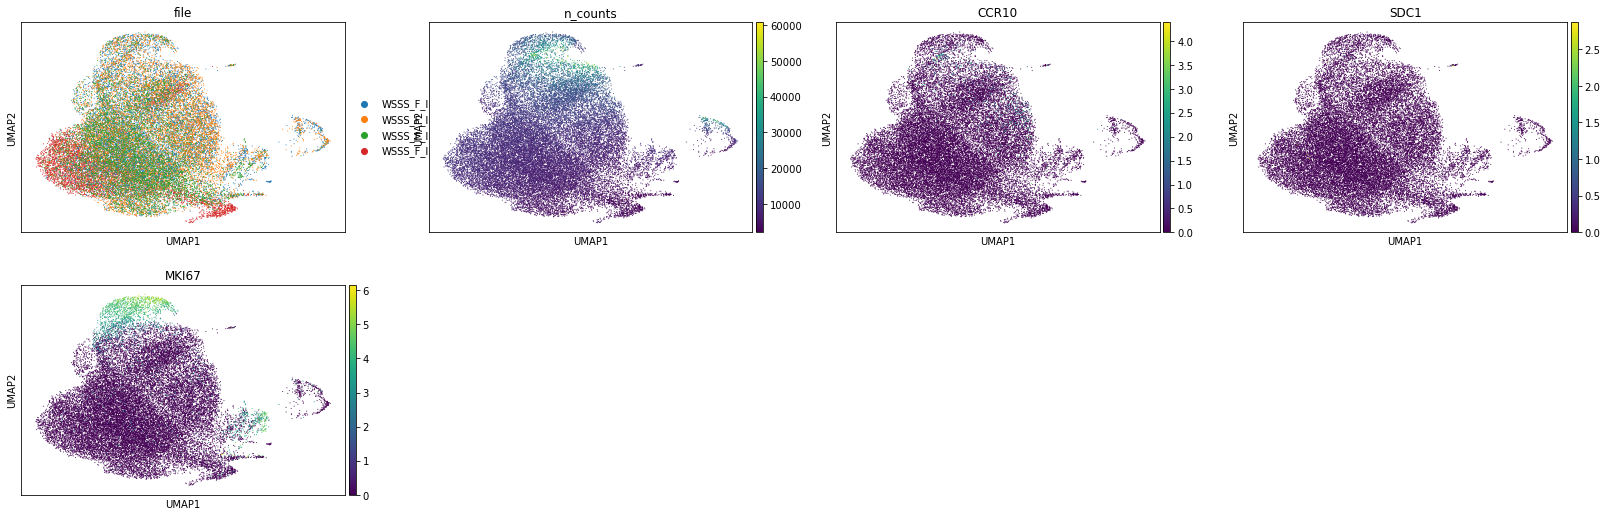

In [31]:
sc.pl.umap(sortedB_adata, color=['file', 'n_counts', "CCR10", "SDC1", "MKI67"])